# Fetching Data

In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
root_path = "WESAD"
zip_label = "_E4_Data.zip"
E4_label = "_E4_Data"

In [3]:
pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled",
    6: "Error/Not Labeled",
    7: "Error/Not Labeled"
}

In [4]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']

In [5]:
subjects_available = os.listdir(root_path)

In [6]:
def get_input_chest_data(subjects_list):
    
    chest_df_list = []
    
    for subject in subjects_list:
        
        pkl_path = os.path.join(root_path, subject, subject + ".pkl")
        f=open(pkl_path,'rb')
        data=pickle.load(f,encoding='latin1')
        
        index_df = [i for i in range(1, len(data["label"]) + 1)]

        chest_data = {
            body_signal: data["signal"]["chest"][body_signal].reshape(len(data["signal"]["chest"][body_signal]),)
            for body_signal in chest_signal_available
        }
        chest_data["subject"] = data["subject"]
        chest_data["label_id"] = data["label"]
        chest_data["label"] = [pacient_state[i]  for i in data["label"]]

        chest_df_list.append(pd.DataFrame(chest_data, index = index_df))
        
    return chest_df_list

In [7]:
input_chest_data = get_input_chest_data(subjects_available)

# Investigating Data

In [8]:
sample_df = input_chest_data[0]

sample_df

,ECG,EMG,EDA,Temp,Resp,subject,label_id,label
1,-1.333694,-0.013687,0.716019,33.695862,0.213623,S10,0,Not Defined/Transient
2,-1.327744,-0.021927,0.714493,33.741333,0.192261,S10,0,Not Defined/Transient
3,-1.322067,-0.009018,0.715637,33.717072,0.205994,S10,0,Not Defined/Transient
4,-1.316345,-0.002380,0.714874,33.741333,0.193787,S10,0,Not Defined/Transient
5,-1.310257,0.001053,0.715256,33.747406,0.172424,S10,0,Not Defined/Transient
...,...,...,...,...,...,...,...,...
3847196,0.522949,0.017029,1.720810,35.015808,-2.032471,S10,0,Not Defined/Transient
3847197,0.526932,0.002060,1.707077,35.018921,-2.030945,S10,0,Not Defined/Transient
3847198,0.530502,0.006546,1.704407,35.020447,-2.183533,S10,0,Not Defined/Transient
3847199,0.533752,-0.001419,1.748276,34.932495,-2.003479,S10,0,Not Defined/Transient


<AxesSubplot:>

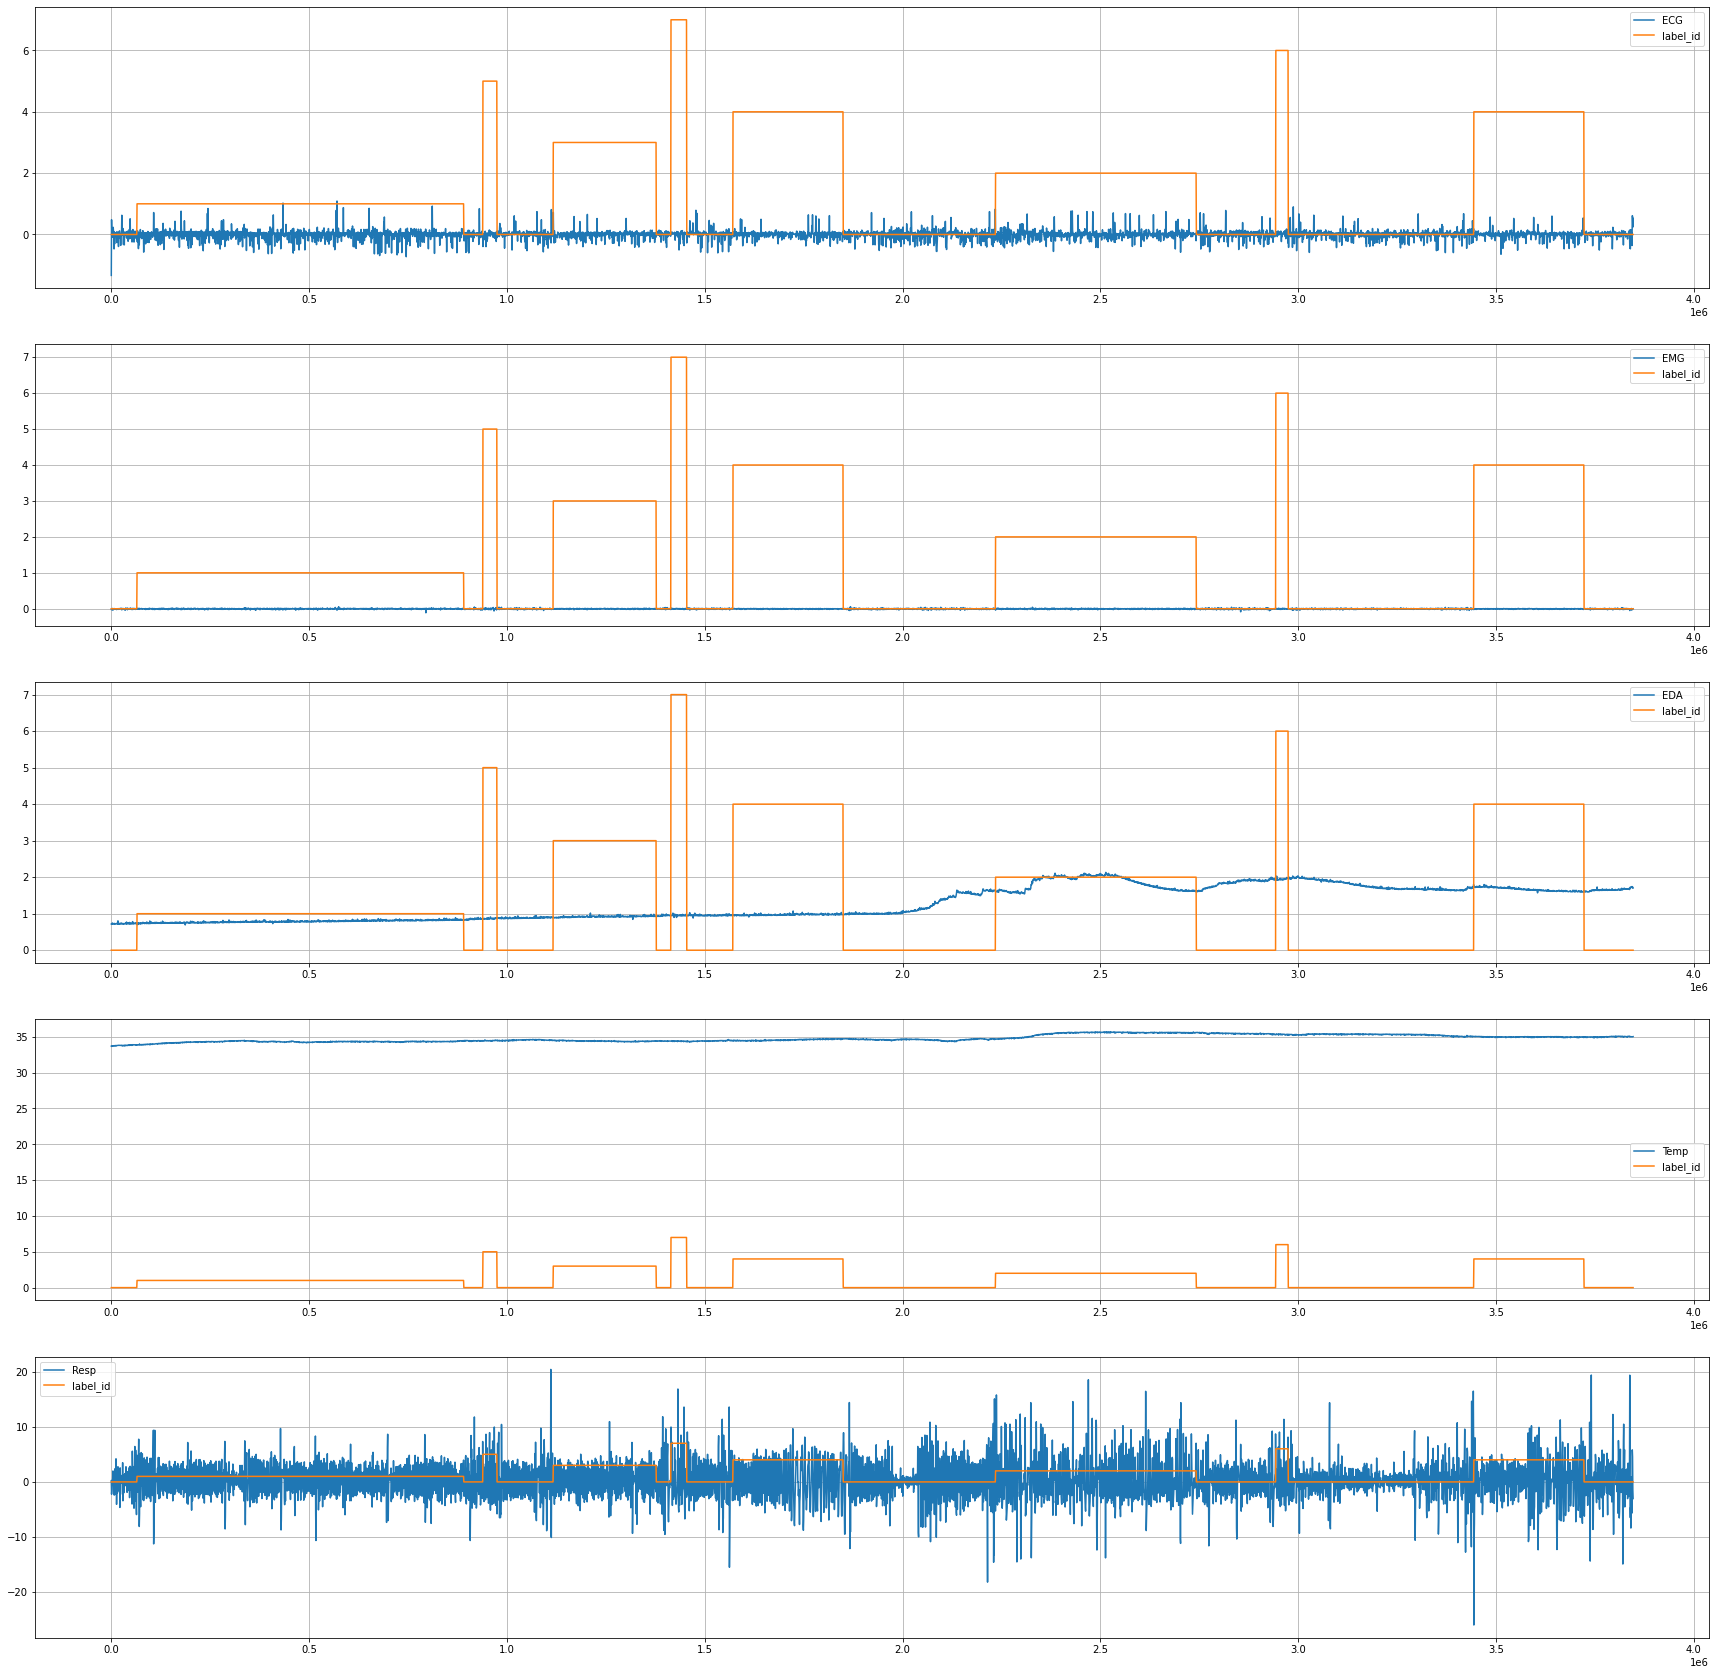

In [9]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

sample_df[::700].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)

In [10]:
sample_corr_df  = sample_df.corr("pearson")

sample_corr_df

,ECG,EMG,EDA,Temp,Resp,label_id
ECG,1.000000,-0.159615,-0.000054,0.000009,0.012907,0.000192
EMG,-0.159615,1.000000,-0.010648,-0.011981,0.000159,-0.003744
EDA,-0.000054,-0.010648,1.000000,0.923337,-0.001085,-0.027200
Temp,0.000009,-0.011981,0.923337,1.000000,-0.000154,-0.026514
Resp,0.012907,0.000159,-0.001085,-0.000154,1.000000,-0.002492
label_id,0.000192,-0.003744,-0.027200,-0.026514,-0.002492,1.000000


<AxesSubplot:>

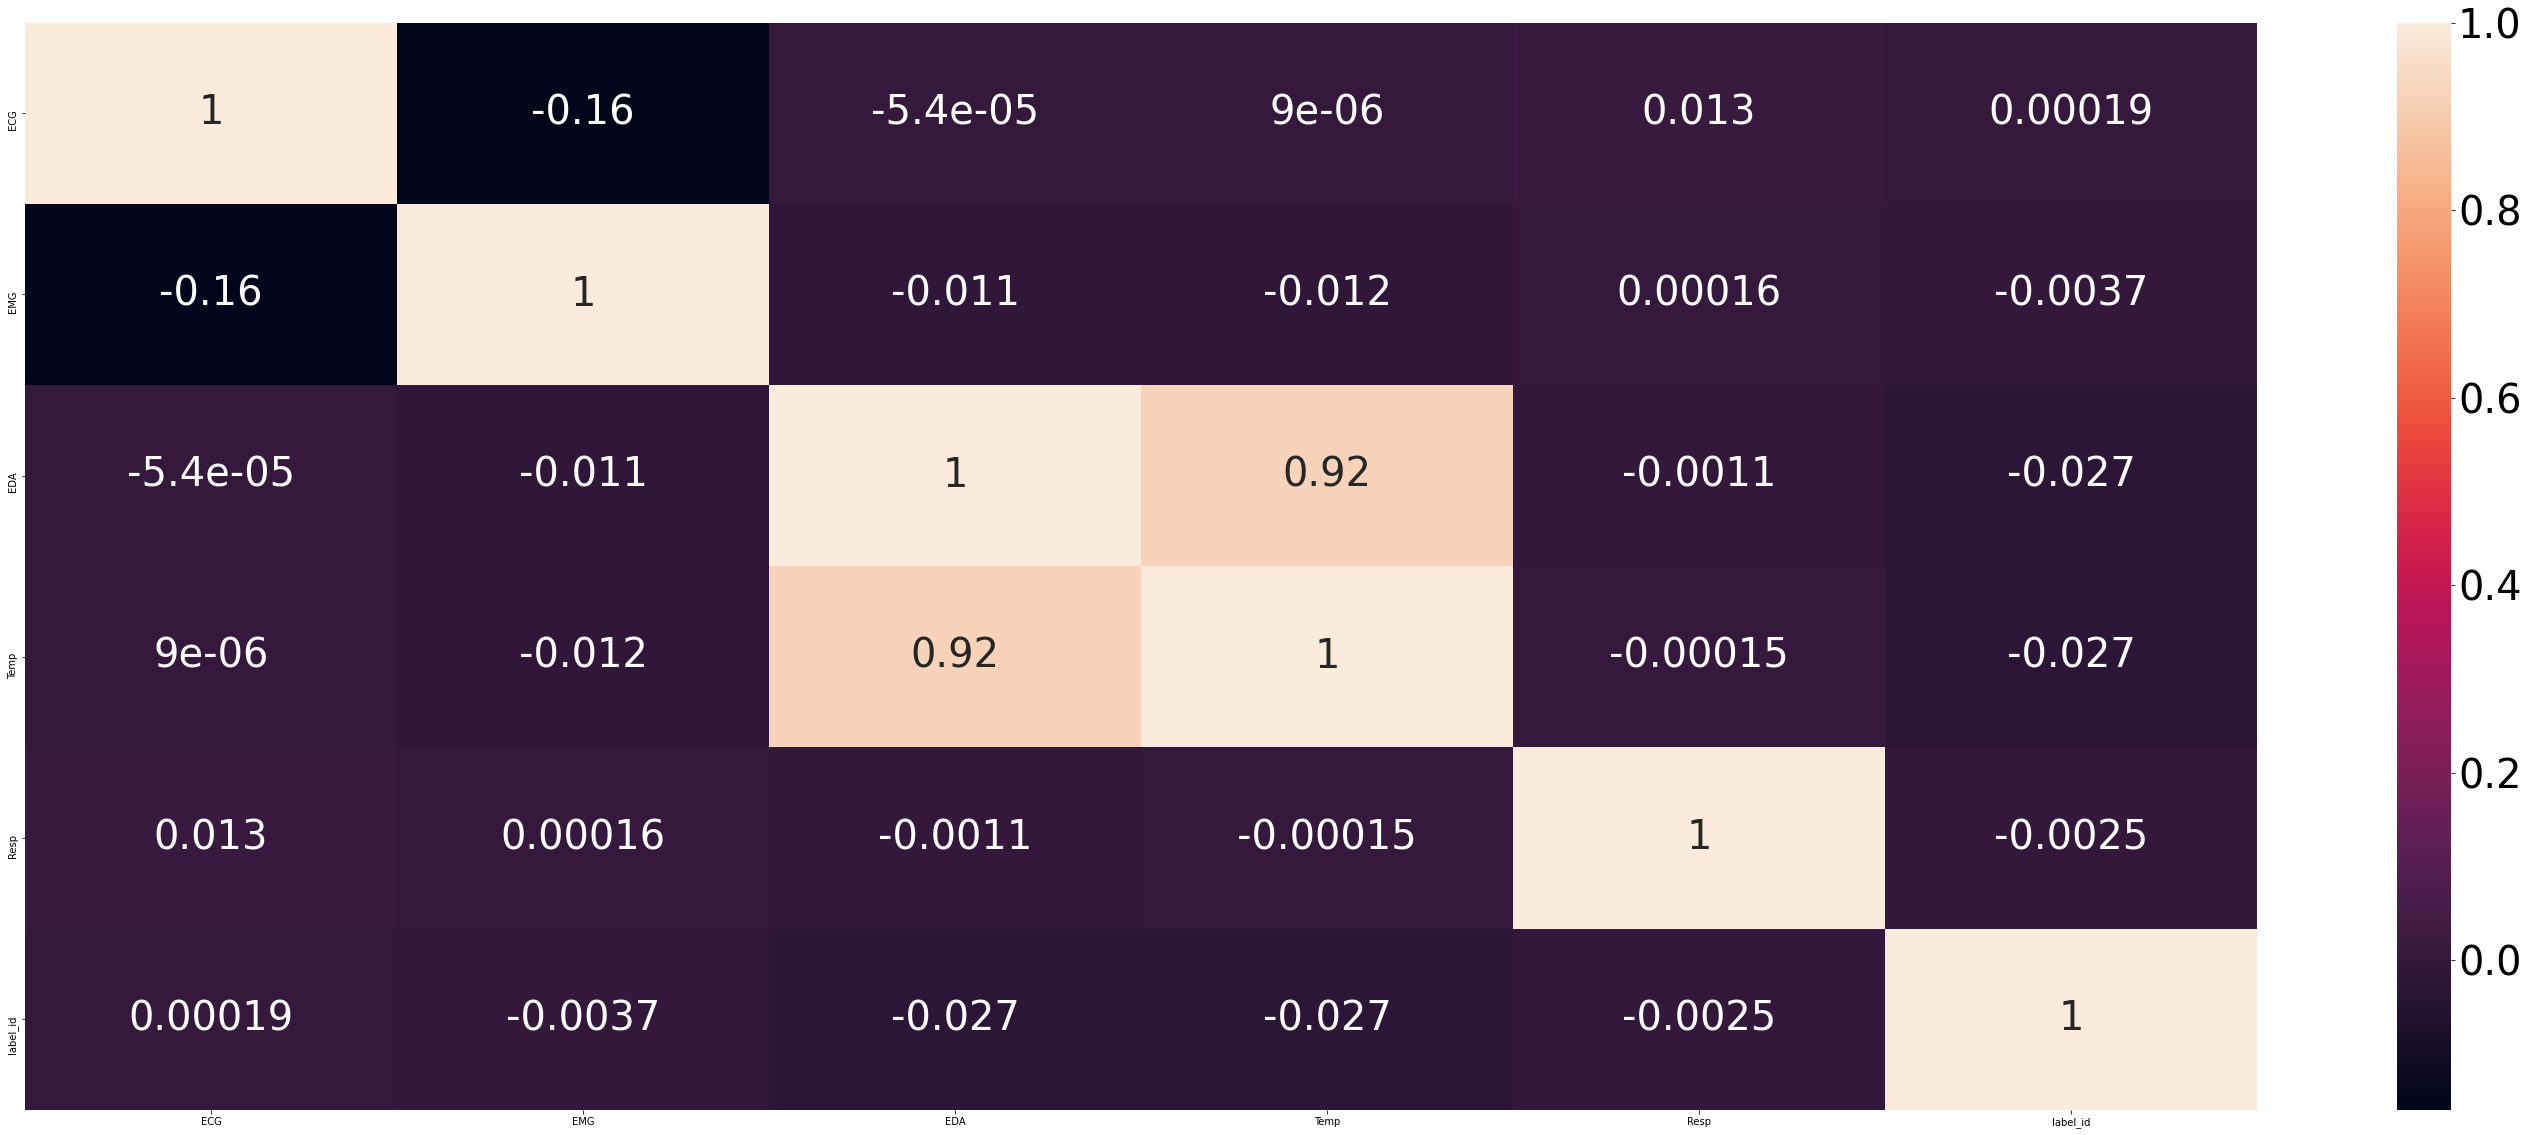

In [11]:
fig,ax_corr = plt.subplots(1, 1, figsize=(50,20))
plt.rcParams.update({'font.size': 40})

sn.heatmap(sample_corr_df, annot=True, ax=ax_corr)

# Cleaning Data

In [12]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [13]:
pacient_state_list  = [[state, pacient_state[state]] for state in pacient_state]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(pacient_state_list)

enc.categories_

[array([0, 1, 2, 3, 4, 5, 6, 7], dtype=object),
 array(['Amusement', 'Baseline', 'Error/Not Labeled', 'Meditation',
        'Not Defined/Transient', 'Stress'], dtype=object)]

In [61]:
win_size = 60 # represent 1 minute

def simple_rolling_z_score(x, window):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [15]:
def rolling_z_score(df, win_size):

    copy_df = df.copy()

    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        mean = df[slicer].mean()
        std = df[slicer].std(ddof=0)

        copy_df[slicer] = (df[slicer] - mean) / std

    return copy_df


In [16]:
clean_chest_data = []

for data_df in input_chest_data:

    # resampling data choosing one point each 700 points

    resample_data_df = data_df[::700]

    # apllying one hot encoder

    label = resample_data_df.pop("label").to_numpy()
    label_id = resample_data_df.pop("label_id").to_numpy()

    label_list = [[label_id[i], label[i]] for i in range(len(resample_data_df))]

    target = enc.transform(label_list).toarray()

    # applying rolling score-z

    subject_label = resample_data_df.pop("subject").to_numpy()[0]

    nodmalized_data_df = rolling_z_score(
        resample_data_df,
        win_size
    )

    # tuple = (normalized_data_df, target, subject_label)

    clean_chest_data.append((nodmalized_data_df, target, subject_label))



In [17]:
sample = clean_chest_data[0]

In [18]:
sample

(              ECG       EMG       EDA      Temp      Resp
 1       -5.284552 -0.716667 -0.892131 -2.260638  0.114234
 701      2.750028 -0.565830 -0.551338 -1.773574 -1.241856
 1401     0.292426 -1.977876 -0.389471 -1.496541 -0.825565
 2101    -0.397018  0.914721  0.763412 -2.968296  0.140404
 2801     0.132320  0.832655 -0.891463 -1.087659 -0.368647
 ...           ...       ...       ...       ...       ...
 3843701 -1.993469 -0.376275  2.447488 -0.700350 -1.141627
 3844401  3.252492 -0.913643  1.161828 -0.894879  1.182826
 3845101  3.158615 -0.015673  1.939203 -1.187634  0.932095
 3845801  1.245760 -0.436376  1.729910 -0.845765 -0.293046
 3846501  2.785086 -0.005067  0.937585 -0.359444 -0.609172
 
 [5496 rows x 5 columns],
 array([[1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.]]),
 'S10')

In [19]:
sample_data_df = sample[0]

In [20]:
sample_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,5496.0,-0.001769,1.005492,-5.462672,-0.286751,0.111028,0.416423,5.674512
EMG,5496.0,-0.003203,1.013699,-6.252469,-0.606008,0.063493,0.653759,5.054707
EDA,5496.0,-0.073789,1.204607,-5.312911,-0.965873,-0.260218,0.748113,5.585704
Temp,5496.0,-0.125602,1.180756,-3.976451,-0.970695,0.004096,0.767865,4.166869
Resp,5496.0,-0.004528,1.020221,-5.795686,-0.689901,-0.086050,0.643312,5.225879


In [21]:
sample_target = sample[1]

In [22]:
unique_values = np.unique(sample_target, axis=0)

In [23]:
unique_values

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [24]:
decode_unique_values = enc.inverse_transform(unique_values)

In [25]:
decode_unique_values

array([[7, 'Error/Not Labeled'],
       [6, 'Error/Not Labeled'],
       [5, 'Error/Not Labeled'],
       [4, 'Meditation'],
       [3, 'Amusement'],
       [2, 'Stress'],
       [1, 'Baseline'],
       [0, 'Not Defined/Transient']], dtype=object)

# Windowing

In [32]:
def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    return unique[most_repeted_element_index]

In [69]:
def get_window_and_related_target(df, np_array, win_size):
    windows_list = []
    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        windows_list.append((df[slicer], get_most_repeted_element(np_array[i:win_size+i])))
    return np.array(windows_list)

In [70]:
sample_window_target = get_window_and_related_target(sample_data_df, sample_target, win_size)

C:\Users\I546644\AppData\Local\Temp/ipykernel_25248/4276140885.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [71]:
sample_window_target[0]

array([            ECG       EMG       EDA      Temp      Resp
1     -5.284552 -0.716667 -0.892131 -2.260638  0.114234
701    2.750028 -0.565830 -0.551338 -1.773574 -1.241856
1401   0.292426 -1.977876 -0.389471 -1.496541 -0.825565
2101  -0.397018  0.914721  0.763412 -2.968296  0.140404
2801   0.132320  0.832655 -0.891463 -1.087659 -0.368647
3501   0.794791 -1.225543  0.526985 -2.630120  0.239893
4201  -0.027178 -2.885498  0.172801 -1.855404  1.031691
4901   1.492781 -0.161600 -0.741011 -1.132124  0.466558
5601   0.694168 -0.483716 -0.185769 -1.859152  0.734002
6301  -0.566695 -0.721900 -0.344911 -1.345183 -1.244612
7001  -2.478234  0.743957 -0.259428 -0.828271 -0.976730
7701   0.559507 -0.671675 -1.092395 -2.395465  0.458590
8401  -1.702485  0.457809  0.234698 -1.488290 -1.306384
9101  -0.891625  0.018096 -0.672323 -0.980353  0.052292
9801   0.300961 -0.878809 -1.090422 -0.878402  1.223362
10501 -0.051522 -1.043816 -1.082466 -2.113507 -0.625188
11201  0.414692  0.229316 -0.614254 -0.56

In [72]:
sample_window_target[1]

array([            ECG       EMG       EDA      Temp      Resp
701    2.750028 -0.565830 -0.551338 -1.773574 -1.241856
1401   0.292426 -1.977876 -0.389471 -1.496541 -0.825565
2101  -0.397018  0.914721  0.763412 -2.968296  0.140404
2801   0.132320  0.832655 -0.891463 -1.087659 -0.368647
3501   0.794791 -1.225543  0.526985 -2.630120  0.239893
4201  -0.027178 -2.885498  0.172801 -1.855404  1.031691
4901   1.492781 -0.161600 -0.741011 -1.132124  0.466558
5601   0.694168 -0.483716 -0.185769 -1.859152  0.734002
6301  -0.566695 -0.721900 -0.344911 -1.345183 -1.244612
7001  -2.478234  0.743957 -0.259428 -0.828271 -0.976730
7701   0.559507 -0.671675 -1.092395 -2.395465  0.458590
8401  -1.702485  0.457809  0.234698 -1.488290 -1.306384
9101  -0.891625  0.018096 -0.672323 -0.980353  0.052292
9801   0.300961 -0.878809 -1.090422 -0.878402  1.223362
10501 -0.051522 -1.043816 -1.082466 -2.113507 -0.625188
11201  0.414692  0.229316 -0.614254 -0.560955 -0.407912
11901 -0.012636 -0.118724 -0.570543 -1.08

In [73]:
input_model_data = []
input_model_window = []
target_model = []

for data in clean_chest_data:

    data_df = data[0]
    data_target = data[1]

    window_target = get_window_and_related_target(data_df, data_target, win_size)

    input_model_data.append(window_target)
    input_model_window.append(window_target[:,0])
    target_model.append(window_target[:,1])
    

C:\Users\I546644\AppData\Local\Temp/ipykernel_25248/4276140885.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [74]:
len(input_model_data)

15

In [75]:
# input_model_data[all windows_target of a subject][specific window_target][window or target]
# input_model_window[all windows_target of a subject][specific window]
# terget_model[all windows_target of a subject][specific target]

input_model_data[0][0][0].equals(input_model_window[0][0])

True

In [77]:
(target_model[0][0] == input_model_data[0][0][1]).all()

True

In [78]:
sample_window_target[0][0].equals(input_model_window[0][0])

True

In [80]:
(sample_window_target[0][1] == input_model_data[0][0][1]).all()

True

## Testing some stuffs